# Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](http://www.up.pt/) compiled this data into a CSV file, which you'll work with in this project. The file contains `17380 rows`, with each row representing the number of bike rentals for a single hour of a single day. We can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here's what the first five rows look like:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here are the descriptions for the relevant columns:

+ `instant` - A unique sequential ID number for each row
+ `dteday` - The date of the rentals
+ `season` - The season in which the rentals occurred
+ `yr` - The year the rentals occurred
+ `mnth` - The month the rentals occurred
+ `hr` - The hour the rentals occurred
+ `holiday` - Whether or not the day was a holiday
+ `weekday` - The day of the week (as a number, `0` to `7`)
+ `workingday` - Whether or not the day was a working day
+ `weathersit` - The weather (as a categorical variable)
+ `temp` - The temperature, on a `0-1` scale
+ `atemp` - The adjusted temperature
+ `hum` - The humidity, on a `0-1` scale
+ `windspeed` - The wind speed, on a `0-1` scale
+ `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
+ `registered` - The number of registered riders (people who had already signed up)
+ `cnt` - The total number of bike rentals (`casual` + `registered`)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

## Introduction to the Dataset

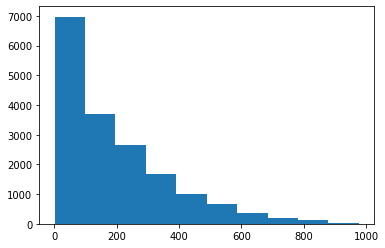

In [3]:
%matplotlib inline

plt.hist(bike_rentals['cnt'])
plt.show()

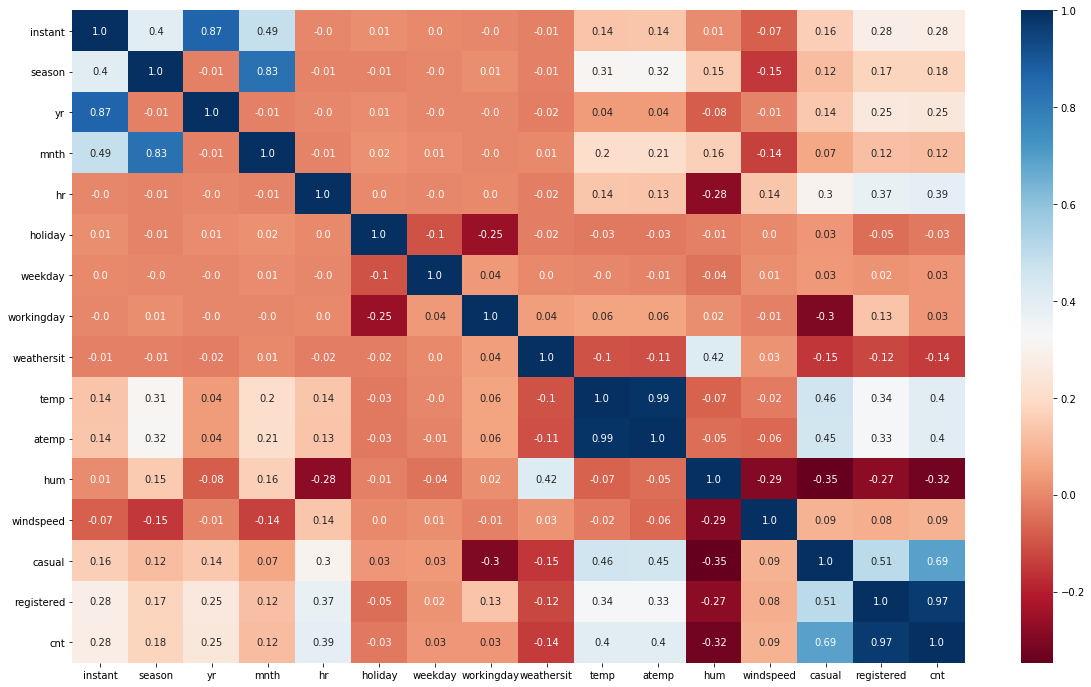

In [4]:
plt.figure(figsize=(20,12))
ax = sns.heatmap(bike_rentals.corr(), cmap='RdBu', annot=True)
for text in ax.texts:
    t = float(text.get_text())
    t = text.set_text(round(t, 2))
plt.show()

## Calculating Features

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.

For example, the `hr` column in `bike_rentals` contains the hours during which bikes are rented, from `1` to `24`. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for `morning`, `afternoon`, `evening`, and `night`. This bundles similar times together, enabling the model to make better decisions.

In [5]:
def assign_label(num):
    if 6 < num <= 12:
        return 1
    elif 12 < num <= 18:
        return 2
    elif 18 < num <= 24:
        return 3
    else:
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals[['hr','time_label']].head(20)

,hr,time_label
0,0,4
1,1,4
2,2,4
3,3,4
4,4,4
5,5,4
6,6,4
7,7,1
8,8,1
9,9,1


## Splitting the Data Into Train and Test Sets

Before we can begin applying machine learning algorithms, we'll need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. If we train an algorithm on the training data, then evaluate its performance on the same data, we can get an unrealistically low error value, due to overfitting.

In [6]:
train = bike_rentals.sample(frac=.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression

Now that we've done some exploration and manipulation, we're ready to apply linear regression to the data. Linear regression works fairly well on this data, given that many of the columns are highly correlated with cnt.

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

We'll need to ignore the `casual` and `registered` columns because `cnt` is derived from them. If we're trying to predict the number of people who rent bikes in a given hour (`cnt`), it doesn't make sense that we'd already know `casual` or `registered`, because those numbers are added together to get `cnt`.

In [7]:
columns = ['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[columns], train['cnt'])
lr_predictions = lr.predict(test[columns])
lr_mse = mean_squared_error(test['cnt'], lr_predictions)
lr_mse

15848.500195099277

## Applying Decision Trees

Now we're ready to apply the decision tree algorithm. We'll be able to compare the decision tree algorithm error with the error from linear regression, which will enable us to pick the right algorithm for this dataset.

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [8]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(train[columns], train['cnt'])
clf_predictions = clf.predict(test[columns])
clf_mse = mean_squared_error(test['cnt'], clf_predictions)
clf_mse

6458.231012658228

## Applying Random Forests

We can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(train[columns], train['cnt'])
rf_predictions = rf.predict(test[columns])
rf_mse = mean_squared_error(test['cnt'], rf_predictions)
rf_mse

1881.2774812140394